In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme(color_codes=True)
import missingno as msno
import tqdm

In [5]:
%pip install matplotlib
%pip install seaborn
%pip install missingno

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


버전 확인

- `python` >= 3.10.12
- `numpy` >= 1.26.0
- `pandas` >= 2.1.1
- `matplotlib` >= 3.8.1
- `seaborn` >= 0.13.0
- `missingno` >= 0.5.2

In [3]:
import sys, matplotlib

print("="*5 ,"나의 라이브러리 버전 확인", "="*5)
print(f"{'python version':15s} <> {sys.version}")
print(f"{'numpy version':15s} <> {np.__version__}")
print(f"{'pandas version':15s} <> {pd.__version__}")
print(f"{'matplotlib version':15s} <> {matplotlib.__version__}")
print(f"{'seaborn version':15s} <> {sns.__version__}")
print(f"{'missingno version':15s} <> {msno.__version__}")

===== 나의 라이브러리 버전 확인 =====
python version  <> 3.10.13 (main, Sep 11 2023, 13:44:35) [GCC 11.2.0]
numpy version   <> 1.26.3
pandas version  <> 2.1.4
matplotlib version <> 3.8.2
seaborn version <> 0.13.1
missingno version <> 0.5.2


In [4]:
%%time
dtype = {
    'userID': 'int16',
    'answerCode': 'int8',
    'KnowledgeTag': 'int16'
}
train = pd.read_csv('/data/ephemeral/home/level2-dkt-recsys-06/data/train_data.csv', dtype=dtype, parse_dates=['Timestamp'])
test = pd.read_csv('/data/ephemeral/home/level2-dkt-recsys-06/data/test_data.csv', dtype=dtype, parse_dates=['Timestamp'])

df = pd.concat([train, test])
df = df.sort_values(by=['userID', 'Timestamp']).reset_index(drop=True)

CPU times: user 5.15 s, sys: 799 ms, total: 5.95 s
Wall time: 5.95 s


In [5]:
df.head()

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225


In [6]:
###### FEATURE AUGMENTATION ######

# SolvingTime, CumulativeTime : 해당 문제를 푸는데 걸린 시간(초), 해당 시험지 내에서 해당 문제 전까지 누적 풀이 시간(초)
df['NextTimestamp'] = pd.to_datetime(df.groupby(['userID', 'testId'])['Timestamp'].shift(-1))
df['SolvingTime'] = (df['NextTimestamp'] - df['Timestamp']).dt.total_seconds()
df['CumulativeTime'] = df.groupby(['userID', 'testId'])['SolvingTime'].cumsum()
df = df.drop(columns=['NextTimestamp'])
## Issue : 시험지 내 마지막 문제에 Solvingtime 결측

# Month, DayOfWeek, TimeOfDay : 문제를 푼 달, 요일, 시간대(0~6시는 새벽, 6~12시는 오전, 12~18시는 오후, 18~24시는 밤)
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df['Month'] = df['Timestamp'].dt.month
df['DayOfWeek'] = df['Timestamp'].dt.dayofweek
day_dict = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
df['DayOfWeek'] = df['DayOfWeek'].map(day_dict)
def label_hour(hour):
    if 0 <= hour < 6:
        return 'Dawn'
    elif 6 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 18:
        return 'Afternoon'
    else:
        return 'Night'
df['TimeOfDay'] = df['Timestamp'].dt.hour.apply(label_hour)


# problems_last7days, problems_last30days, problems_cumulative : User가 해당 문제 푼 시점으로부터 7일 전까지, 30일 전까지, 처음까지 푼 누적 문제 수
df = df.sort_values(['userID', 'Timestamp'])
grouped = df.groupby('userID')
df['problems_cumulative'] = grouped.cumcount()

results = []
for name, group in grouped:
    group['problems_last7days'] = group.rolling('7D', on='Timestamp')['assessmentItemID'].count() - 1
    group['problems_last30days'] = group.rolling('30D', on='Timestamp')['assessmentItemID'].count() - 1
    results.append(group)

df = pd.concat(results)
df['problems_last7days'] = df['problems_last7days'].astype(int)
df['problems_last30days'] = df['problems_last30days'].astype(int)

df.head()

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,SolvingTime,CumulativeTime,Month,DayOfWeek,TimeOfDay,problems_cumulative,problems_last7days,problems_last30days
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,3.0,3.0,3,Tuesday,Dawn,0,0,0
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,8.0,11.0,3,Tuesday,Dawn,1,1,1
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,7.0,18.0,3,Tuesday,Dawn,2,2,2
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,7.0,25.0,3,Tuesday,Dawn,3,3,3
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,11.0,36.0,3,Tuesday,Dawn,4,4,4


In [7]:
# same_tag_last7days, same_tag_last30days, same_tag_cumulative : 모든 문제가 아니라 같은 KnowledgeTag를 가진 문제에 대해서만 위와 같이 계산한 컬럼
df = df.sort_values(['userID', 'KnowledgeTag', 'Timestamp'])
grouped = df.groupby(['userID', 'KnowledgeTag'])

results = []
for (userID, KnowledgeTag), group in tqdm.tqdm(grouped):
    group['same_tag_last7days'] = group.rolling('7D', on='Timestamp')['assessmentItemID'].count()
    group['same_tag_last30days'] = group.rolling('30D', on='Timestamp')['assessmentItemID'].count()
    group['same_tag_cumulative'] = group['assessmentItemID'].expanding().count()
    results.append(group)

df = pd.concat(results)
df['same_tag_last7days'] = df['same_tag_last7days'].astype(int)
df['same_tag_last30days'] = df['same_tag_last30days'].astype(int)
df['same_tag_cumulative'] = df['same_tag_cumulative'].astype(int)
## Issue : userID * KnowledgeTag 개수(over 100000)만큼의 그룹을 생성한 후 연산해야만 하는 컬럼이라 연산 시간이 많이 소요됨. 매번 생성하지 않고 한번 생성 후 csv파일 형태로 사용해야 할듯

df = df.sort_values(['userID', 'Timestamp'])
df = df[df['answerCode'] != -1]

df.head()

100%|██████████| 492354/492354 [33:50<00:00, 242.47it/s]  


,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,SolvingTime,CumulativeTime,Month,DayOfWeek,TimeOfDay,problems_cumulative,problems_last7days,problems_last30days,same_tag_last7days,same_tag_last30days,same_tag_cumulative
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,3.0,3.0,3,Tuesday,Dawn,0,0,0,1,1,1
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,8.0,11.0,3,Tuesday,Dawn,1,1,1,1,1,1
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,7.0,18.0,3,Tuesday,Dawn,2,2,2,2,2,2
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,7.0,25.0,3,Tuesday,Dawn,3,3,3,3,3,3
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,11.0,36.0,3,Tuesday,Dawn,4,4,4,4,4,4


In [8]:
df.to_csv('augment.csv', index=False)

In [9]:
def percentile(s):
    return np.sum(s) / len(s)

In [10]:
stu_groupby = df.groupby('userID').agg({
    'assessmentItemID': 'count',
    'answerCode': percentile
})
stu_groupby.describe()

,assessmentItemID,answerCode
count,7442.000000,7442.000000
mean,339.418973,0.628749
std,321.465413,0.159608
min,9.000000,0.000000
25%,78.000000,0.526782
50%,232.500000,0.651923
75%,519.000000,0.750728
max,1860.000000,1.000000


In [17]:
df[df['SolvingTime'] > 10000]['answerCode'].mean()

0.6212750253713443

## (a)

In [16]:
itemnum_ans = stu_groupby.groupby('assessmentItemID').mean()
itemnum_ans['num_items'] = itemnum_ans.index

Text(0, 0.5, 'Answer Rate')

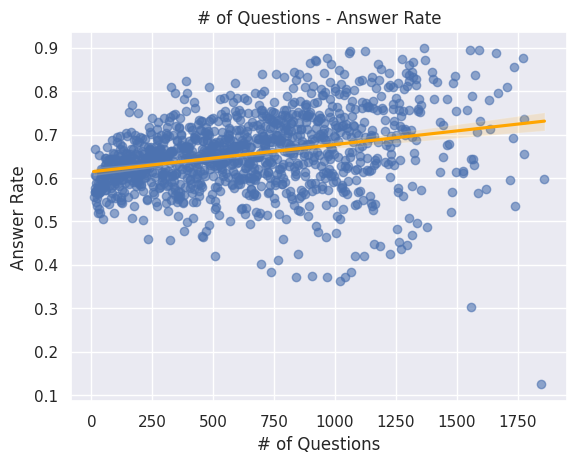

In [17]:
fig, ax = plt.subplots()
sns.regplot(data=itemnum_ans, x='num_items', y='answerCode',
           line_kws={"color": "orange"}, scatter_kws={'alpha':0.6}, ax=ax)

ax.set_title('# of Questions - Answer Rate')
ax.set_xlabel('# of Questions')
ax.set_ylabel('Answer Rate')

## (b)

In [18]:
itemnum_ans = stu_groupby.groupby('assessmentItemID').mean()
bins = 300
itemnum_ans['bins'] = pd.cut(
    itemnum_ans.index,
    [i * (itemnum_ans.index.max() - itemnum_ans.index.min()) // bins for i in range(bins)]
)

In [19]:
itemnum_ans = itemnum_ans.groupby('bins').mean()
itemnum_ans['mid'] = list(map(lambda x: (x.left + x.right)//2, itemnum_ans.index))

/tmp/ipykernel_351048/894362937.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  itemnum_ans = itemnum_ans.groupby('bins').mean()


Text(0, 0.5, 'Answer Rate')

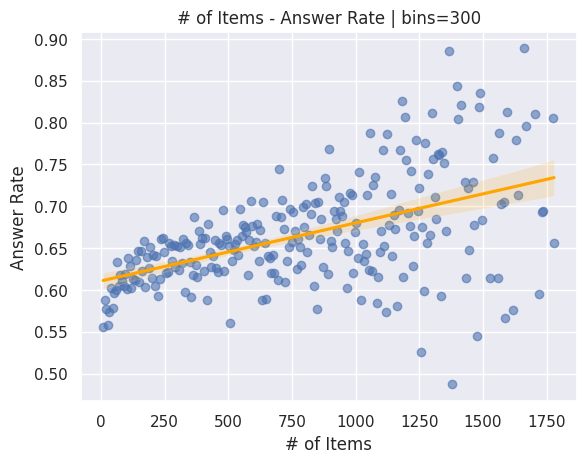

In [20]:
fig, ax = plt.subplots()
sns.regplot(data=itemnum_ans, x='mid', y='answerCode',
           line_kws={"color": "orange"}, scatter_kws={'alpha': 0.6}, ax=ax)

ax.set_title(f'# of Items - Answer Rate | bins={bins}')
ax.set_xlabel('# of Items')
ax.set_ylabel('Answer Rate')